作者：李豪文

# 导入工具包

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import pylab as pl
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
#解决中文显示问题
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 读取数据

In [158]:
G = pd.read_csv('GlobalTemperatures.csv')
G = G[['dt','LandAverageTemperature']]
G.columns = ['Date','Temp']
G['Date'] = pd.to_datetime(G['Date'])
G.reset_index(drop=True, inplace=True)
G.set_index('Date', inplace=True)
G = G.loc['1900':'2013-01-01']
G = G.asfreq('M', method='bfill')
print('缺失数据：', len([pd.isna(G.Temp)])-1)
G = G[G.index.year>=1960]
G.head()

缺失数据： 0


,Temp
Date,
1960-01-31,3.798
1960-02-29,4.303
1960-03-31,8.133
1960-04-30,10.872
1960-05-31,13.484


 训练集与测试集

In [159]:
G_test = G[G.index.year>2010]
G = G[G.index.year<=2010]

# 时间序列分析

Text(0,0.5,'温度')

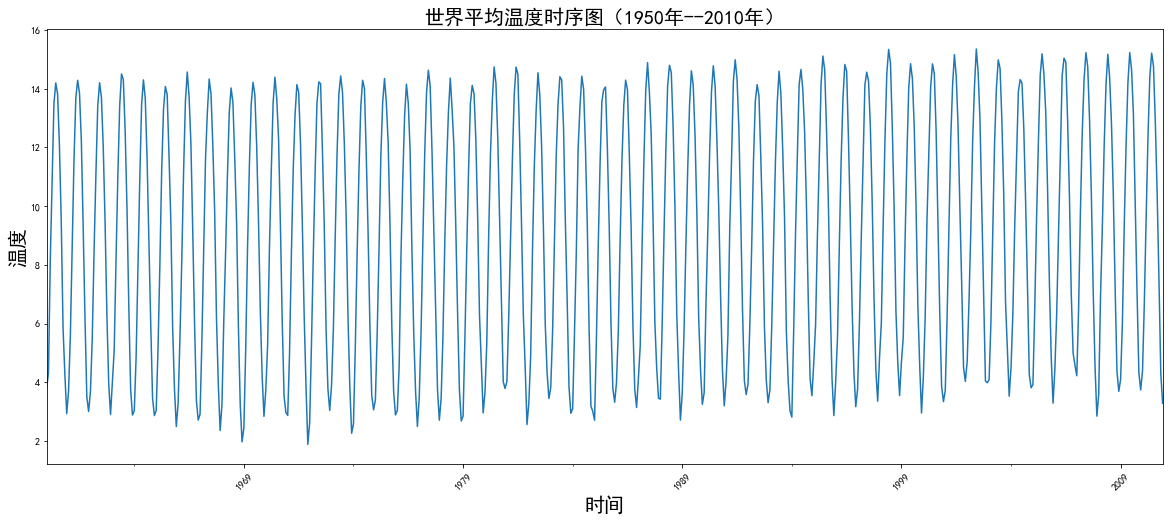

In [160]:
G.Temp.plot(figsize=(20,8))
pl.xticks(rotation=45)
plt.title('世界平均温度时序图（1950年--2010年）',fontsize=20)
plt.xlabel('时间',fontsize=20)
plt.ylabel('温度',fontsize=20)

## 季节性

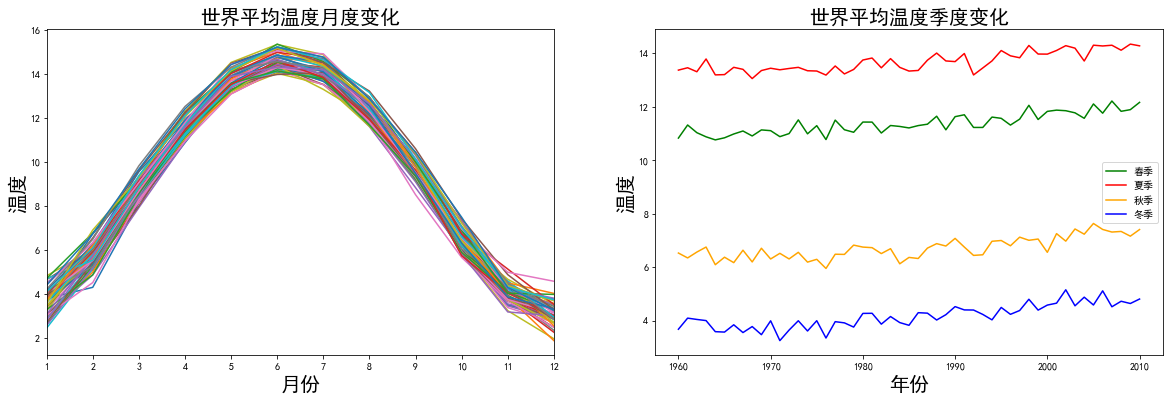

In [161]:
# i'm going to create a pivot table to plot the monthly temperatures through the years
G['month'] = G.index.month
G['year'] = G.index.year
pivot = pd.pivot_table(G, values='Temp', index='month', columns='year', aggfunc='mean')
def get_season(month):
    if month >= 3 and month <= 5:
        return '春季'
    elif month >= 6 and month <= 8:
        return '夏季'
    elif month >= 9 and month <= 11:
        return '秋季'
    else:
        return '冬季'
G['season'] = G['month'].apply(get_season)
SeasonTemp = G.groupby([G['season'],G['year']]).mean()
S = {'春季':'g','夏季':'r','秋季':'orange','冬季':'b'}

plt.figure(figsize=(20,8))
ax1 = plt.subplot(1,2,1)
pivot.plot(figsize=(20,6),ax=ax1)
plt.title('世界平均温度月度变化',fontsize=20)
plt.xlabel('月份',fontsize=20)
plt.ylabel('温度',fontsize=20)
plt.xticks([x for x in range(1,13)])
plt.legend().remove()

ax2 = plt.subplot(1,2,2)
plt.xlabel('年份',fontsize=20)
plt.ylabel('温度',fontsize=20)
plt.title('世界平均温度季度变化',fontsize=20)
for s in S.keys():
    plt.plot(SeasonTemp.loc[s].Temp,color=S[s])
plt.legend(S.keys())

### 趋势

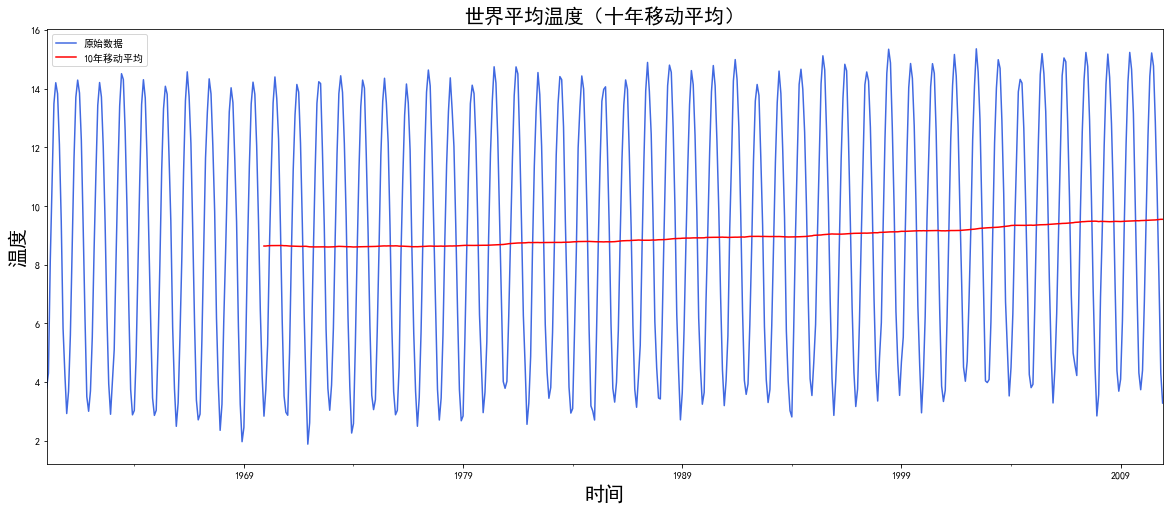

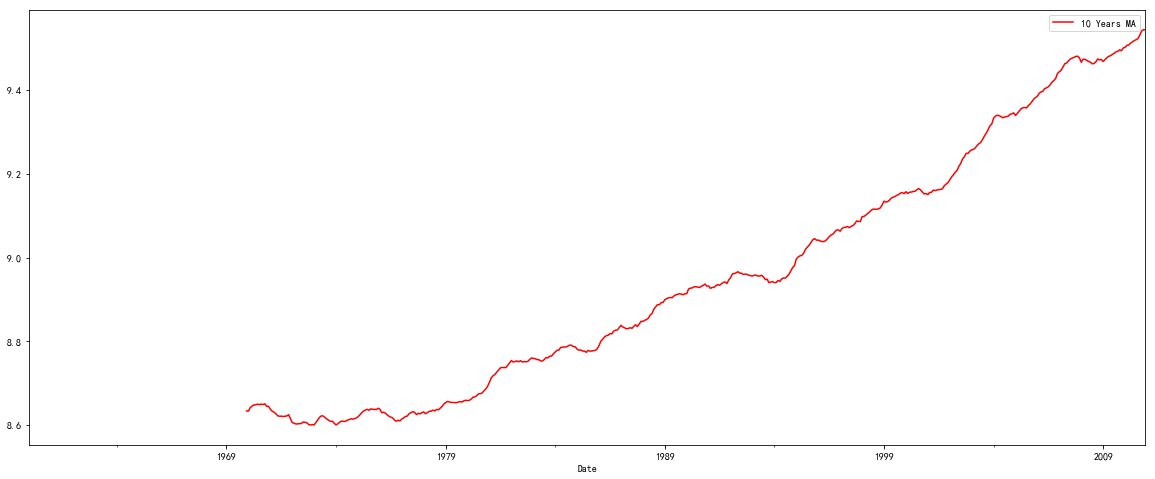

In [200]:
G['10 Years MA'] = G['Temp'].rolling(12*10).mean()
G[['Temp','10 Years MA']].plot(color=['royalblue','r'],figsize=(20,8))
plt.title('世界平均温度（十年移动平均）',fontsize=20)
plt.xlabel('时间',fontsize=20)
plt.ylabel('温度',fontsize=20)
plt.legend(['原始数据','10年移动平均'])
plt.show()
G[['10 Years MA']].plot(color='r',figsize=(20,8))

# 成分分解

Text(0,0.5,'不规则波动成分')

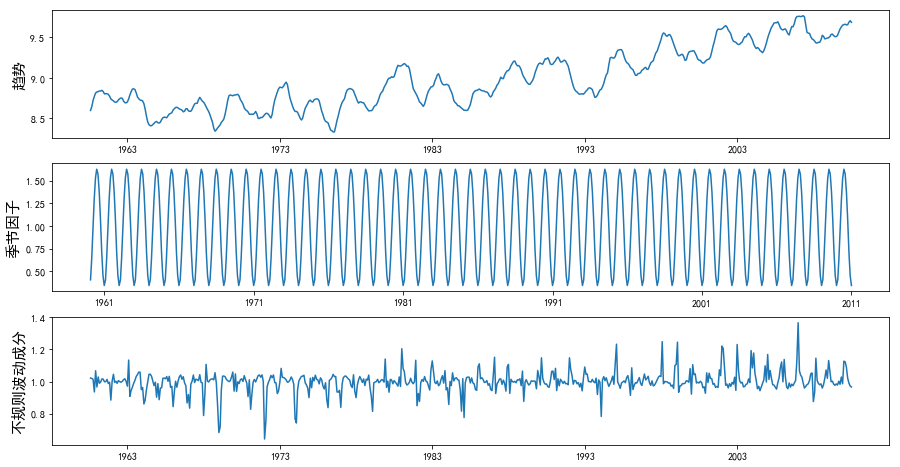

In [167]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(G.Temp, model="multiplicative")
plt.figure(figsize=(15,8))
plt.subplot(3,1,1)
plt.plot(decomposition.trend)
plt.ylabel('趋势',fontsize=15)
plt.subplot(3,1,2)
plt.plot(decomposition.seasonal)
plt.ylabel('季节因子',fontsize=15)
plt.subplot(3,1,3)
plt.plot(decomposition.resid)
plt.ylabel('不规则波动成分',fontsize=15)

## 平稳性检验

ADF检验

In [197]:
def ADF(y):
    #ADF检验
    print('ADF检验结果:')
    adfinput = adfuller(y)
    adftest = pd.Series(adfinput[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    adftest = round(adftest,4)
    
    for key, value in adfinput[4].items():
        adftest["Critical Value (%s)"%key] = value.round(4)
        
    print(adftest)
    
    if adftest[0].round(2) < adftest[5].round(2):
        print('\nThe Test Statistics is lower than the Critical Value of 5%.\nThe serie seems to be stationary')
    else:
        print("\nThe Test Statistics is higher than the Critical Value of 5%.\nThe serie isn't stationary")

作时序图、相关图

In [198]:
def check_stationarity(y, Title,lags_plots=36, figsize=(18,8)):
    "Use Series as parameter"
    
    # Creating plots of the DF
    y = pd.Series(y)
    fig = plt.figure()

    ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((3, 3), (1, 0))
    ax3 = plt.subplot2grid((3, 3), (1, 1))
    ax4 = plt.subplot2grid((3, 3), (2, 0), colspan=2)

    y.plot(ax=ax1, figsize=figsize)
    ax1.set_title(Title + '时序图',fontsize=20)
    plot_acf(y, lags=lags_plots, zero=False, ax=ax2,title='自相关图');
    plot_pacf(y, lags=lags_plots, zero=False, ax=ax3,title='偏自相关图');
    sns.distplot(y, bins=int(sqrt(len(y))), ax=ax4)
    ax4.set_title('取值分布图')
    plt.tight_layout()

## 原序列

ADF检验结果:
Test Statistic                  -2.1725
p-value                          0.2164
Lags Used                       14.0000
Number of Observations Used    597.0000
Critical Value (1%)             -3.4414
Critical Value (5%)             -2.8664
Critical Value (10%)            -2.5694
dtype: float64

The Test Statistics is higher than the Critical Value of 5%.
The serie isn't stationary


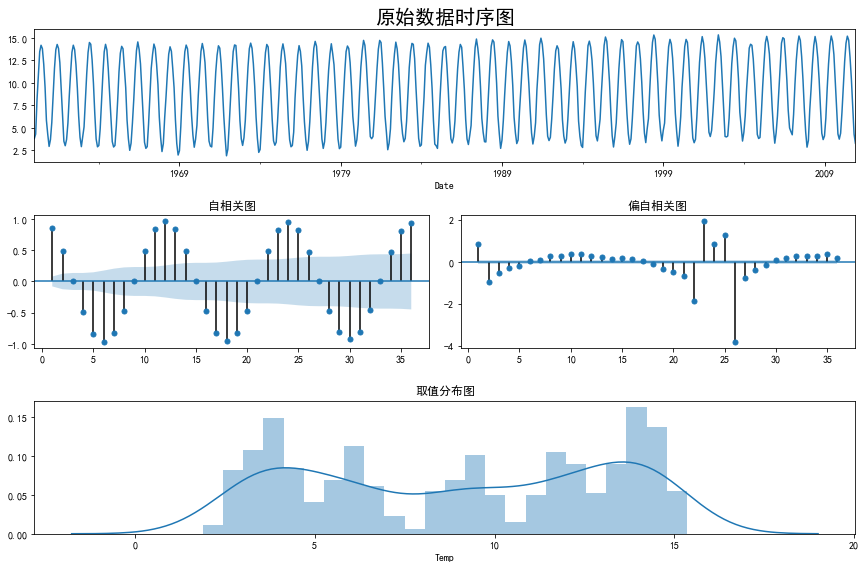

In [199]:
ADF(G.Temp)
check_stationarity(G.Temp,'原始数据')

## 一阶12步差分

ADF检验结果:
Test Statistic                  -8.5188
p-value                          0.0000
Lags Used                       13.0000
Number of Observations Used    586.0000
Critical Value (1%)             -3.4416
Critical Value (5%)             -2.8665
Critical Value (10%)            -2.5694
dtype: float64

The Test Statistics is lower than the Critical Value of 5%.
The serie seems to be stationary


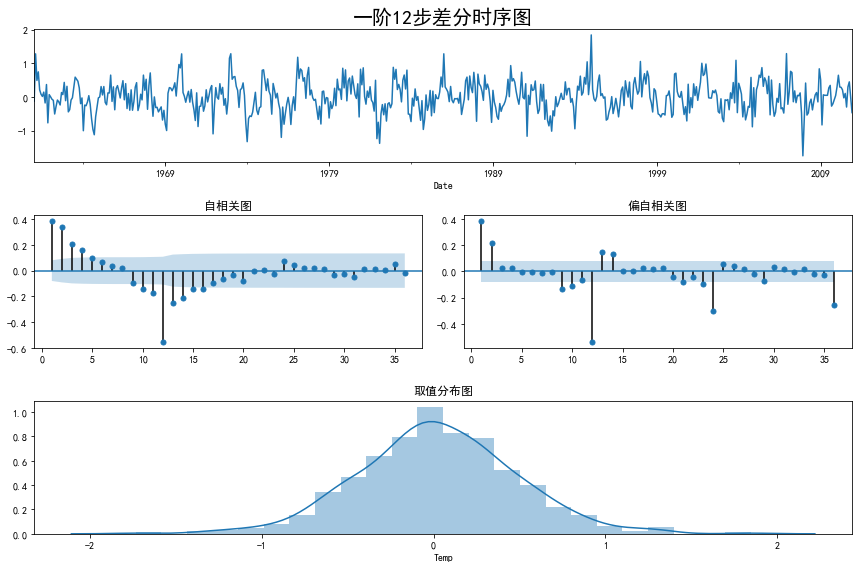

In [196]:
ADF(G['Temp'].diff(12).dropna())
check_stationarity(G['Temp'].diff(12).dropna(),'一阶12步差分')

# 模型确定

# 参数选择

In [203]:
AIC = 1000000;
p_list=[1,2]
q_list=[1,2,3,4]
for p in p_list:
    for q in q_list:
        try:
            model = sm.tsa.SARIMAX(G.Temp, order=(p,1,q), seasonal_order=(0,1,1,12)).fit()
            print(p,q,model.aic)
            if model.aic < AIC:
                AIC = model.aic
        except:
            pass
print('best:',AIC)

1 1 290.607611873
1 2 300.591745959
1 3 271.715849496
1 4 270.814396271
2 1 268.653409291
2 2 270.655432528
2 3 269.085219353
2 4 272.870769916
best: 268.653409291


选择ARIMA(2,1,1)x(0,1,1)_12模型

                                 Statespace Model Results                                 
Dep. Variable:                               Temp   No. Observations:                  612
Model:             SARIMAX(2, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -129.327
Date:                            Sun, 26 May 2019   AIC                            268.653
Time:                                    18:26:02   BIC                            290.630
Sample:                                01-31-1960   HQIC                           277.209
                                     - 12-31-2010                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2877      0.042      6.869      0.000       0.206       0.370
ar.L2          0.2112      0.042   

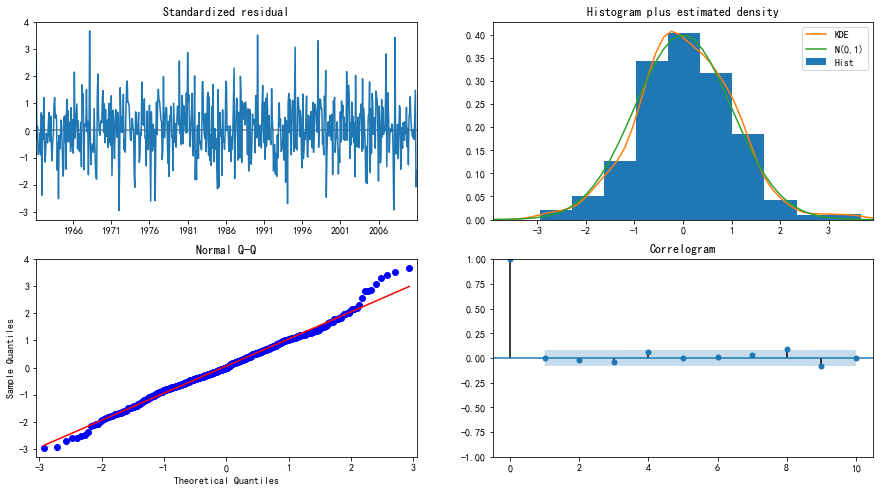

In [206]:
model = sm.tsa.SARIMAX(G.Temp, order=(2,1,1), seasonal_order=(0,1,1,12)).fit()
print(model.summary())
model.plot_diagnostics(figsize=(15,8))
plt.show()

# 残差白噪声检验

Q_LB统计量检验

In [208]:
r, q, p = sm.tsa.acf(model.resid[13:], qstat=True)
data = np.c_[range(1, 41), r[1:], q, p]
table = pd.DataFrame(data, columns=['lag', 'AC', 'Q', 'Prob(>Q)'])
table.ixdex=table.lag
# Prob(>Q)即P值大部分都小于0.05，所以残差不是白噪声
table.loc[[6*x-1 for x in range(1,5)]]

,lag,AC,Q,Prob(>Q)
5,6.0,0.012378,3.319873,0.767760
11,12.0,-0.043023,15.015195,0.240607
17,18.0,-0.003722,19.683570,0.350913
23,24.0,0.088261,25.894337,0.358548


DW检验

In [210]:
print('DW = ',sm.stats.durbin_watson(model.resid[13:]))

DW =  1.95892677463


# 预测

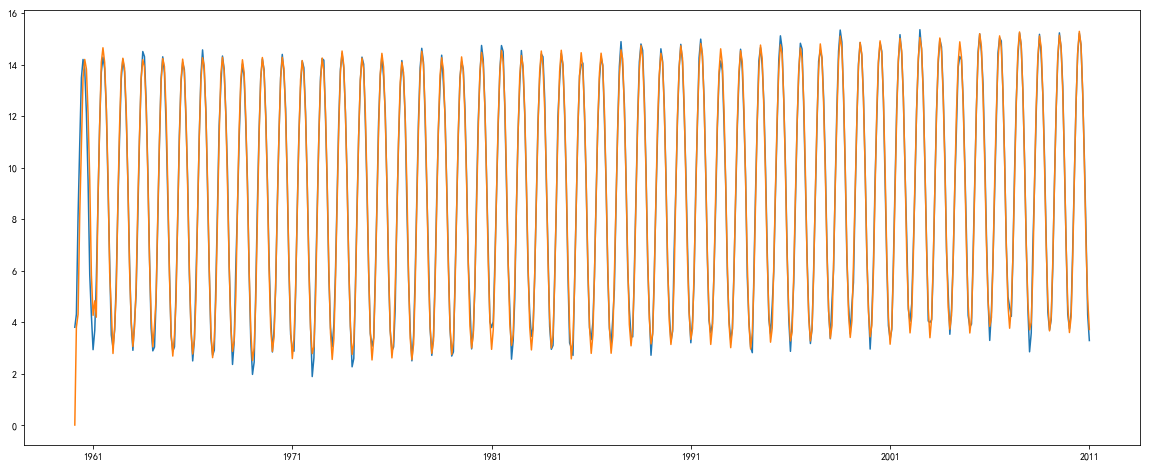

In [212]:
plt.figure(figsize=(20,8))
plt.plot(G.Temp)
plt.plot(model.predict())

Text(0.5,0,'时间')

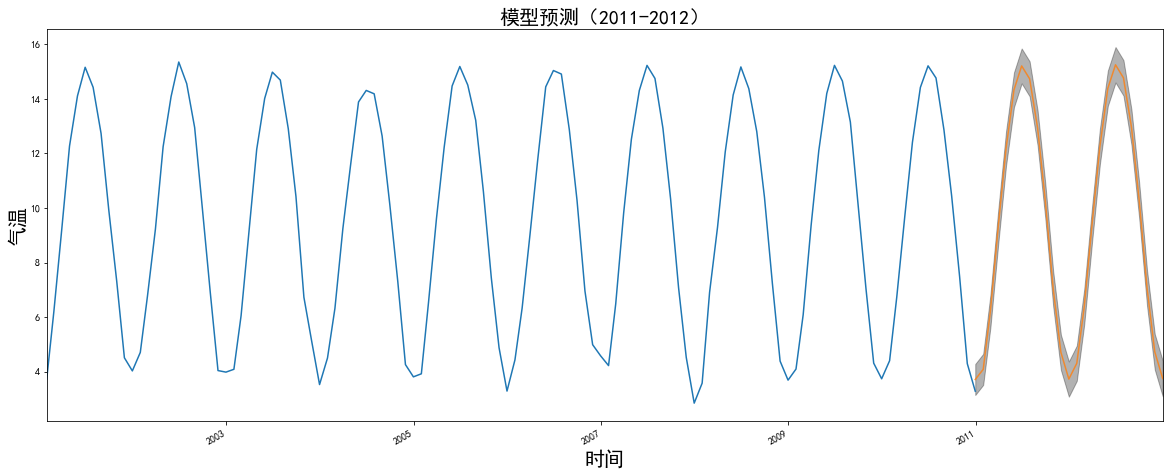

In [268]:
from datetime import datetime
plt.figure(figsize=(20,8))
pred = model.get_prediction(start = datetime(2010, 12, 31),end = datetime(2012, 12, 31))
pred_ci = pred.conf_int()
ax = plt.plot(G.Temp[G.index.year>2000])
pred.predicted_mean.plot(label='One-step ahead Forecast', alpha=.8)
plt.fill_between(pred_ci.index,pred_ci.iloc[:, 0],pred_ci.iloc[:, 1], color='k', alpha=.3)
plt.title('模型预测（2011-2012）',fontsize=20)
plt.ylabel('气温',fontsize=20)
plt.xlabel('时间',fontsize=20)

预测误差

In [263]:
G_pred = pred.predicted_mean
mse = ((G_test.values.T - G_pred.values[1:]) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.08


In [270]:
G_pred.to_csv('世界平均气候预测.csv')